## Training DynEdge

Now that both database and selection is ready, everything is in place to begin training. DynEdge is a GNN implemented in GraphNeT - it represents IceCube events as 3D point clouds and leverages techniques from segmentation analysis in computer vision to reconstruct events. You can find technical details on the model in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003). The model and training configuration shown below is nearly identical to what's presented in the paper. Note that this configuration was originally meant for low energy, so it's possible that some adjustments might improve performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
from copy import deepcopy
from graphnet.data.constants import FEATURES, TRUTH
from icecube_utils import make_dataloader

from icecube_utils import (
    load_pretrained_model,
    make_dataloader,
)
from map_model import (
    compute_activations_across_models_v1,
    layer_names
)
from graphnet.training.labels import Direction
from parameters import get_parser
from train_large import config

features = FEATURES.KAGGLE
truth = TRUTH.KAGGLE

graphnet: INFO     2023-03-23 21:31:43 - get_logger - Writing log to logs/graphnet_20230323-213143.log
graphnet: WARNING  2023-03-23 21:31:49 - warn_once - `icecube` not available. Some functionality may be missing.


In the cell below, you can choose between training dynedge from scratch on the batch_1 database or loading in a pretrained model that has trained on batches 1 to 50.

In [4]:
models = {}

In [5]:
config_small = deepcopy(config)
config_small['dynedge']['dynedge_layer_sizes'] = [(128, 256), (336, 256), (336, 256), (336, 256)]

models['from'] = load_pretrained_model(config=config_small, path='weights/direction/state_dict.pth')

graphnet: INFO     2023-03-23 21:31:52 - load_pretrained_model - Current model state dict keys: odict_keys(['_gnn._conv_layers.0.nn.0.weight', '_gnn._conv_layers.0.nn.0.bias', '_gnn._conv_layers.0.nn.2.weight', '_gnn._conv_layers.0.nn.2.bias', '_gnn._conv_layers.1.nn.0.weight', '_gnn._conv_layers.1.nn.0.bias', '_gnn._conv_layers.1.nn.2.weight', '_gnn._conv_layers.1.nn.2.bias', '_gnn._conv_layers.2.nn.0.weight', '_gnn._conv_layers.2.nn.0.bias', '_gnn._conv_layers.2.nn.2.weight', '_gnn._conv_layers.2.nn.2.bias', '_gnn._conv_layers.3.nn.0.weight', '_gnn._conv_layers.3.nn.0.bias', '_gnn._conv_layers.3.nn.2.weight', '_gnn._conv_layers.3.nn.2.bias', '_gnn._post_processing.0.weight', '_gnn._post_processing.0.bias', '_gnn._post_processing.2.weight', '_gnn._post_processing.2.bias', '_gnn._readout.0.weight', '_gnn._readout.0.bias', '_tasks.0._affine.weight', '_tasks.0._affine.bias'])
graphnet: INFO     2023-03-23 21:31:52 - load_pretrained_model - Loading state dict from weights/direction/state_

In [6]:
config_large = deepcopy(config)
config_large['dynedge']['dynedge_layer_sizes'] = [(128 // 2, 256 // 2), (336 // 2, 256 // 2), (336 // 2, 256 // 2), (336 // 2, 256 // 2)]

models['to'] = load_pretrained_model(config=config_large, path='weights/direction_smaller/state_dict.pth')
models['mapped'] = load_pretrained_model(config=config_large, path='weights/direction_smaller_mapped/state_dict.pth')

graphnet: INFO     2023-03-23 21:31:59 - load_pretrained_model - Current model state dict keys: odict_keys(['_gnn._conv_layers.0.nn.0.weight', '_gnn._conv_layers.0.nn.0.bias', '_gnn._conv_layers.0.nn.2.weight', '_gnn._conv_layers.0.nn.2.bias', '_gnn._conv_layers.1.nn.0.weight', '_gnn._conv_layers.1.nn.0.bias', '_gnn._conv_layers.1.nn.2.weight', '_gnn._conv_layers.1.nn.2.bias', '_gnn._conv_layers.2.nn.0.weight', '_gnn._conv_layers.2.nn.0.bias', '_gnn._conv_layers.2.nn.2.weight', '_gnn._conv_layers.2.nn.2.bias', '_gnn._conv_layers.3.nn.0.weight', '_gnn._conv_layers.3.nn.0.bias', '_gnn._conv_layers.3.nn.2.weight', '_gnn._conv_layers.3.nn.2.bias', '_gnn._post_processing.0.weight', '_gnn._post_processing.0.bias', '_gnn._post_processing.2.weight', '_gnn._post_processing.2.bias', '_gnn._readout.0.weight', '_gnn._readout.0.bias', '_tasks.0._affine.weight', '_tasks.0._affine.bias'])
graphnet: INFO     2023-03-23 21:31:59 - load_pretrained_model - Loading state dict from weights/direction_smalle

In [7]:
parser = get_parser()
args = parser.parse_args('--gpu-id 1 --model-name mlpnet --n-epochs 10 --save-result-file sample.csv \
--sweep-name exp_sample --exact --correction --ground-metric euclidean --weight-stats \
--activation-histograms --activation-mode raw --geom-ensemble-type acts --sweep-id 21 \
--act-num-samples 200 --ground-metric-normalize none --activation-seed 21 \
--prelu-acts --recheck-acc --load-models ./mnist_models --ckpt-type final \
--past-correction --not-squared --dist-normalize --print-distances --to-download'.split())

args.gpu_id = 0
args.proper_marginals = True
args.skip_last_layer = True
args.skip_personal_idx = False
args.act_num_samples = 200
args.width_ratio = 1
args.dataset = 'icecube'

In [8]:
train_dataloader = make_dataloader(db = config_small['path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = args.act_num_samples,
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
    max_n_pulses= config_small['max_n_pulses']['max_n_pulses'],
    max_n_pulses_strategy= 'clamp',
)

In [9]:
tol = 1e-5
for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
        enumerate(zip(models['from'].named_parameters(), models['mapped'].named_parameters())):
    with torch.no_grad():
        if not (
            torch.allclose(fc_layer0_weight.mean(), fc_layer1_weight.mean(), rtol=tol, atol=tol) and
            torch.allclose(fc_layer0_weight.abs().mean(), fc_layer1_weight.abs().mean(), rtol=tol, atol=tol) and 
            torch.allclose((fc_layer0_weight.abs() ** 2).mean(), (fc_layer1_weight.abs() ** 2).sum() ** 0.5, rtol=tol, atol=tol)
        ):
            print(layer0_name, fc_layer0_weight.mean(), fc_layer1_weight.mean())

_gnn._conv_layers.0.nn.0.weight tensor(-0.0047) tensor(-0.0033)
_gnn._conv_layers.0.nn.0.bias tensor(-0.0271) tensor(-0.0192)
_gnn._conv_layers.0.nn.2.weight tensor(-0.0148) tensor(-0.0419)
_gnn._conv_layers.0.nn.2.bias tensor(0.0020) tensor(0.0020)
_gnn._conv_layers.1.nn.0.weight tensor(-0.0028) tensor(-0.0056)
_gnn._conv_layers.1.nn.0.bias tensor(-0.0367) tensor(-0.0367)
_gnn._conv_layers.1.nn.2.weight tensor(-0.0108) tensor(-0.0216)
_gnn._conv_layers.1.nn.2.bias tensor(-0.0120) tensor(-0.0120)
_gnn._conv_layers.2.nn.0.weight tensor(-0.0049) tensor(-0.0099)
_gnn._conv_layers.2.nn.0.bias tensor(-0.0642) tensor(-0.0642)
_gnn._conv_layers.2.nn.2.weight tensor(-0.0110) tensor(-0.0220)
_gnn._conv_layers.2.nn.2.bias tensor(-0.0327) tensor(-0.0327)
_gnn._conv_layers.3.nn.0.weight tensor(-0.0017) tensor(-0.0034)
_gnn._conv_layers.3.nn.0.bias tensor(-0.0634) tensor(-0.0634)
_gnn._conv_layers.3.nn.2.weight tensor(-0.0088) tensor(-0.0176)
_gnn._conv_layers.3.nn.2.bias tensor(0.0267) tensor(0.02

In [10]:
models_names, models_list = [], []
for model_name, model in models.items():
    models_names.append(model_name)
    models_list.append(model.cuda())

with torch.no_grad():
    activations = compute_activations_across_models_v1(
        args, 
        models_list,
        train_dataloader,
        args.act_num_samples,
        mode='raw',
        layer_names=layer_names
    )

graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.0.nn.0
graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.0.nn.2
graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.1.nn.0
graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.1.nn.2
graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.2.nn.0
graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.2.nn.2
graphnet: INFO     2023-03-23 21:32:04 - compute_activations_across_models_v1 - set forward hook for layer named: _gnn._conv_layers.3.nn.0
graphnet: INFO     2023-03-

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will b

graphnet: INFO     2023-03-23 21:32:10 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-23 21:32:11 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-23 21:32:11 - compute_activations_across_models_v1 - num_personal_idx 0
graphnet: INFO     2023-03-23 21:32:11 - compute_activations_across_models_v1 - ***********
graphnet: INFO     2023-03-23 21:32:11 - compute_activations_across_models_v1 - min of act: -2.712292432785034, max: 2.6503500938415527, mean: -0.08888822048902512
graphnet: INFO     2023-03-23 21:32:11 - compute_activations_across_models_v1 - activations for idx 0 at layer _gnn._conv_layers.0.nn.0 have the following shape torch.Size([125349, 128])
graphnet: INFO     2023-03-23 21:32:11 - compute_activations_across_models_v1 - -----------
graphnet: INFO     2023-03-23 21:32:11 - compute_activations_across_models

_gnn._conv_layers.0.nn.0 [torch.Size([125349, 128]), torch.Size([125349, 64]), torch.Size([125349, 64])]
_gnn._conv_layers.0.nn.0 [-2.712292432785034, -1.466726541519165, -1.225525140762329]
_gnn._conv_layers.0.nn.0 [2.6503500938415527, 1.156612753868103, 1.389176845550537]
_gnn._conv_layers.0.nn.0 [1, 0.30471882224082947, 0.1248805820941925]

_gnn._conv_layers.0.nn.2 [torch.Size([125349, 256]), torch.Size([125349, 128]), torch.Size([125349, 128])]
_gnn._conv_layers.0.nn.2 [-7.36140775680542, -0.5161418914794922, -3.931863307952881]
_gnn._conv_layers.0.nn.2 [1.1480300426483154, 0.55177241563797, 0.6758092045783997]
_gnn._conv_layers.0.nn.2 [1, 0.11219993233680725, 0.14535103738307953]

_gnn._conv_layers.1.nn.0 [torch.Size([124784, 336]), torch.Size([124784, 168]), torch.Size([124784, 168])]
_gnn._conv_layers.1.nn.0 [-10.819698333740234, -2.64214825630188, -3.0801663398742676]
_gnn._conv_layers.1.nn.0 [8.859174728393555, 3.0900068283081055, 3.1156744956970215]
_gnn._conv_layers.1.nn.0 [

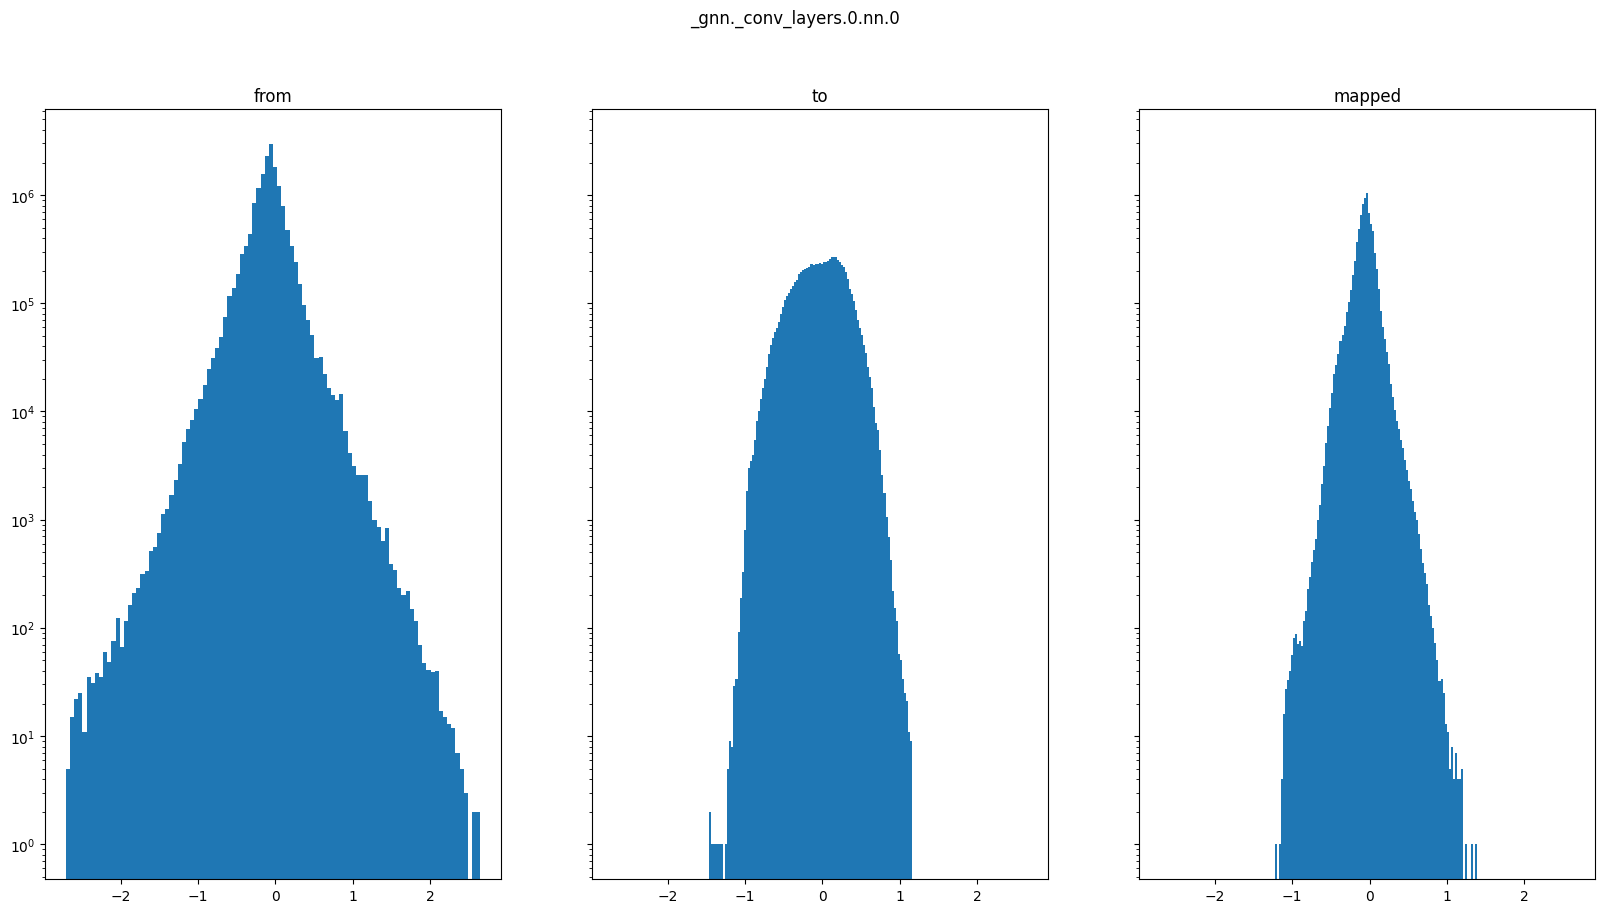

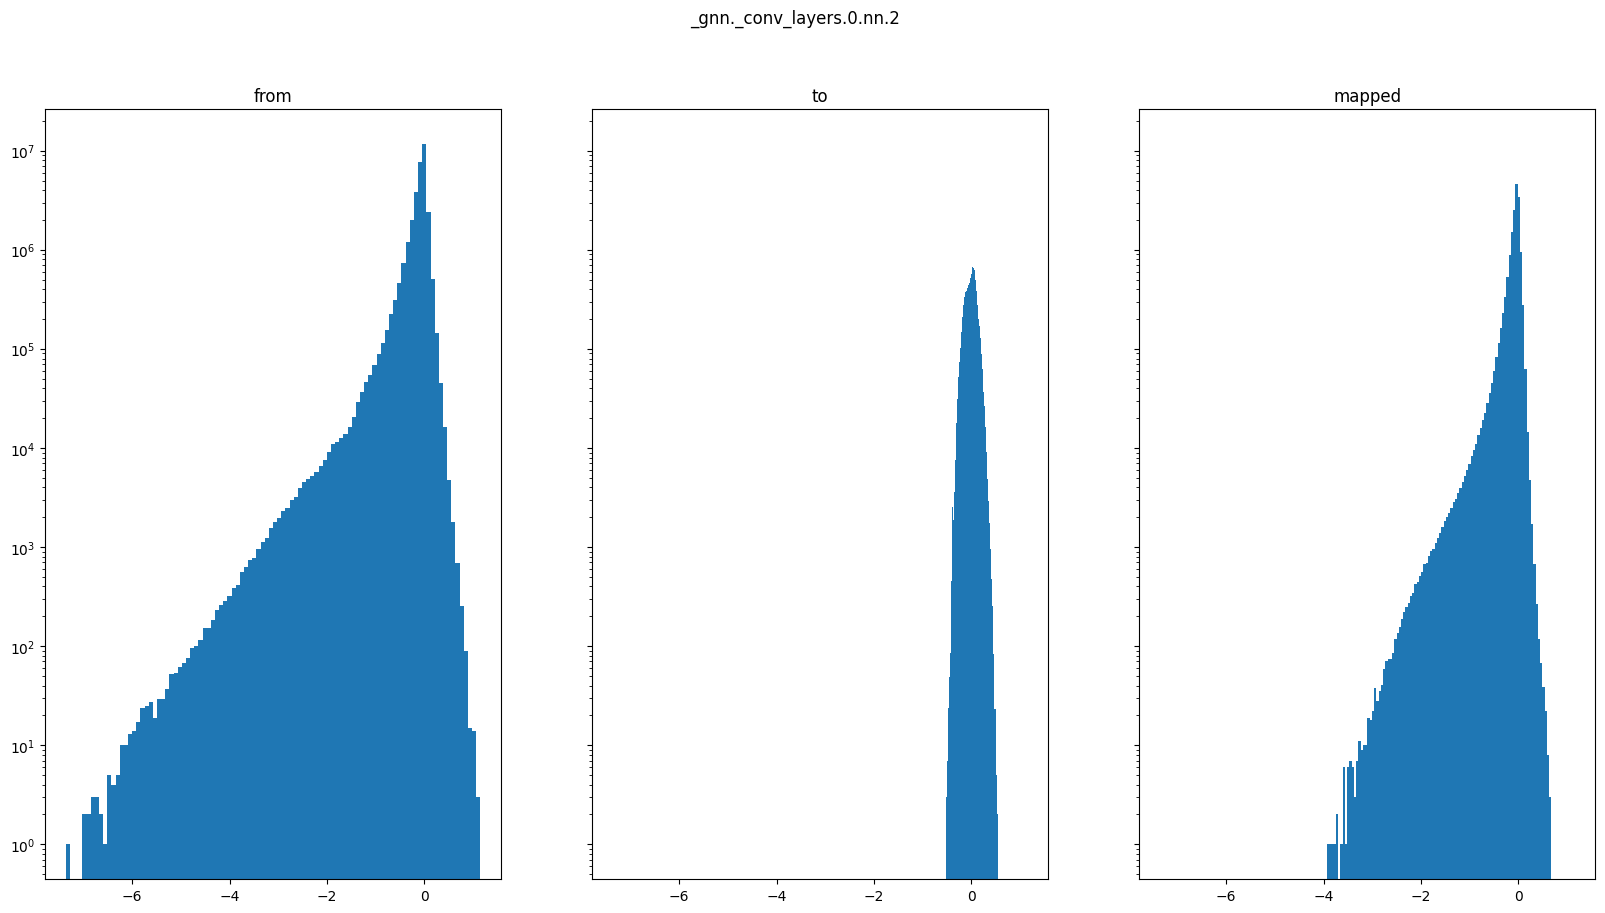

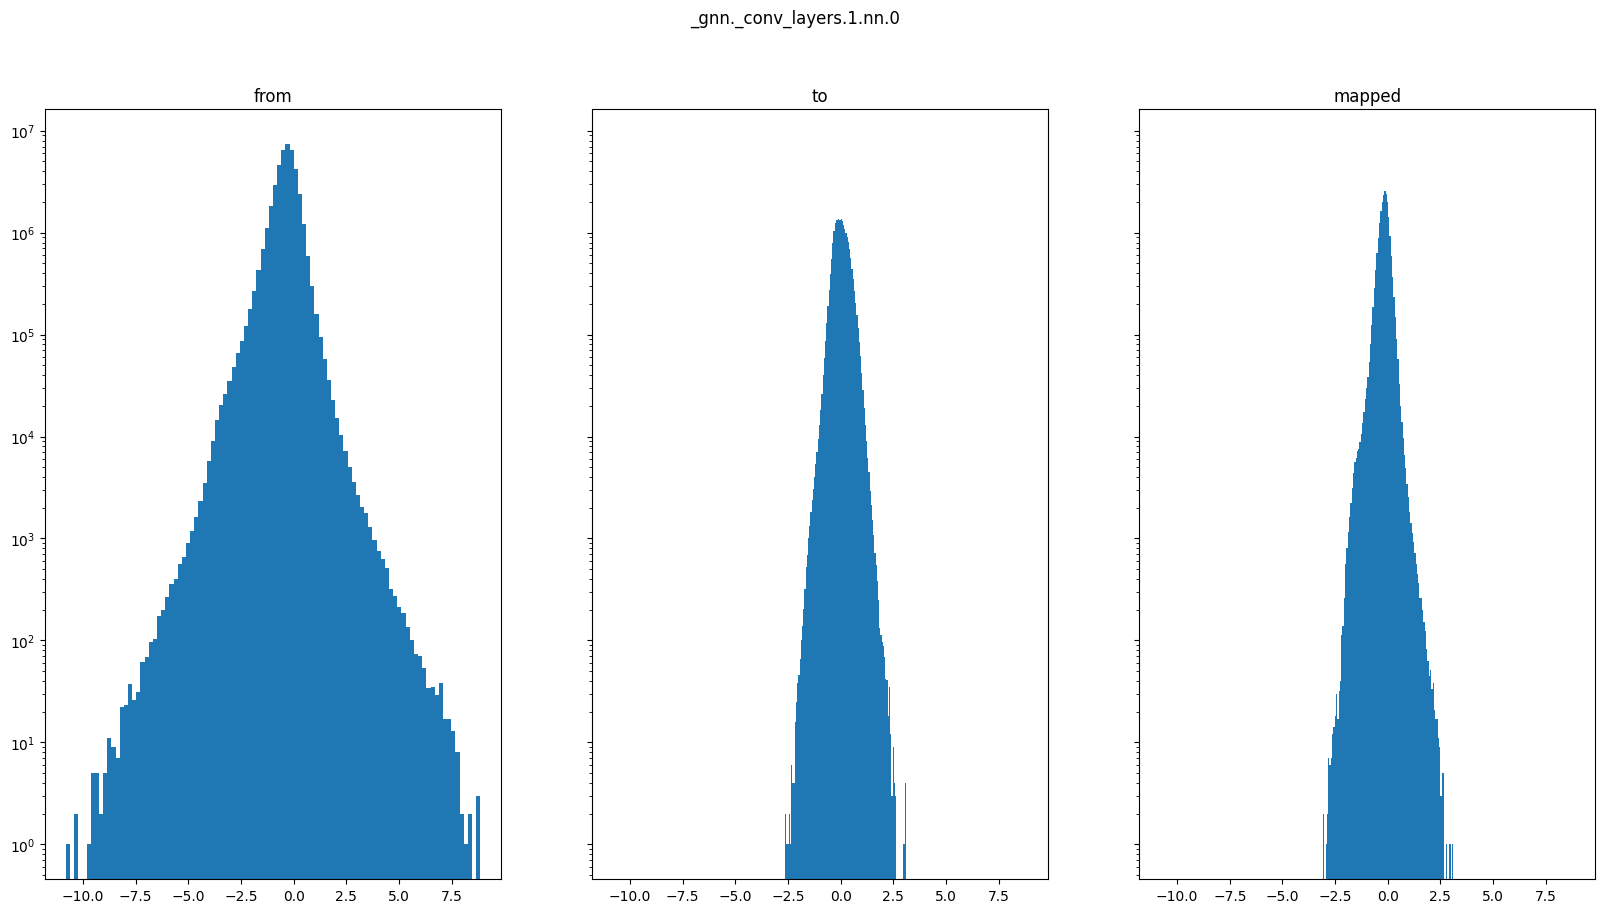

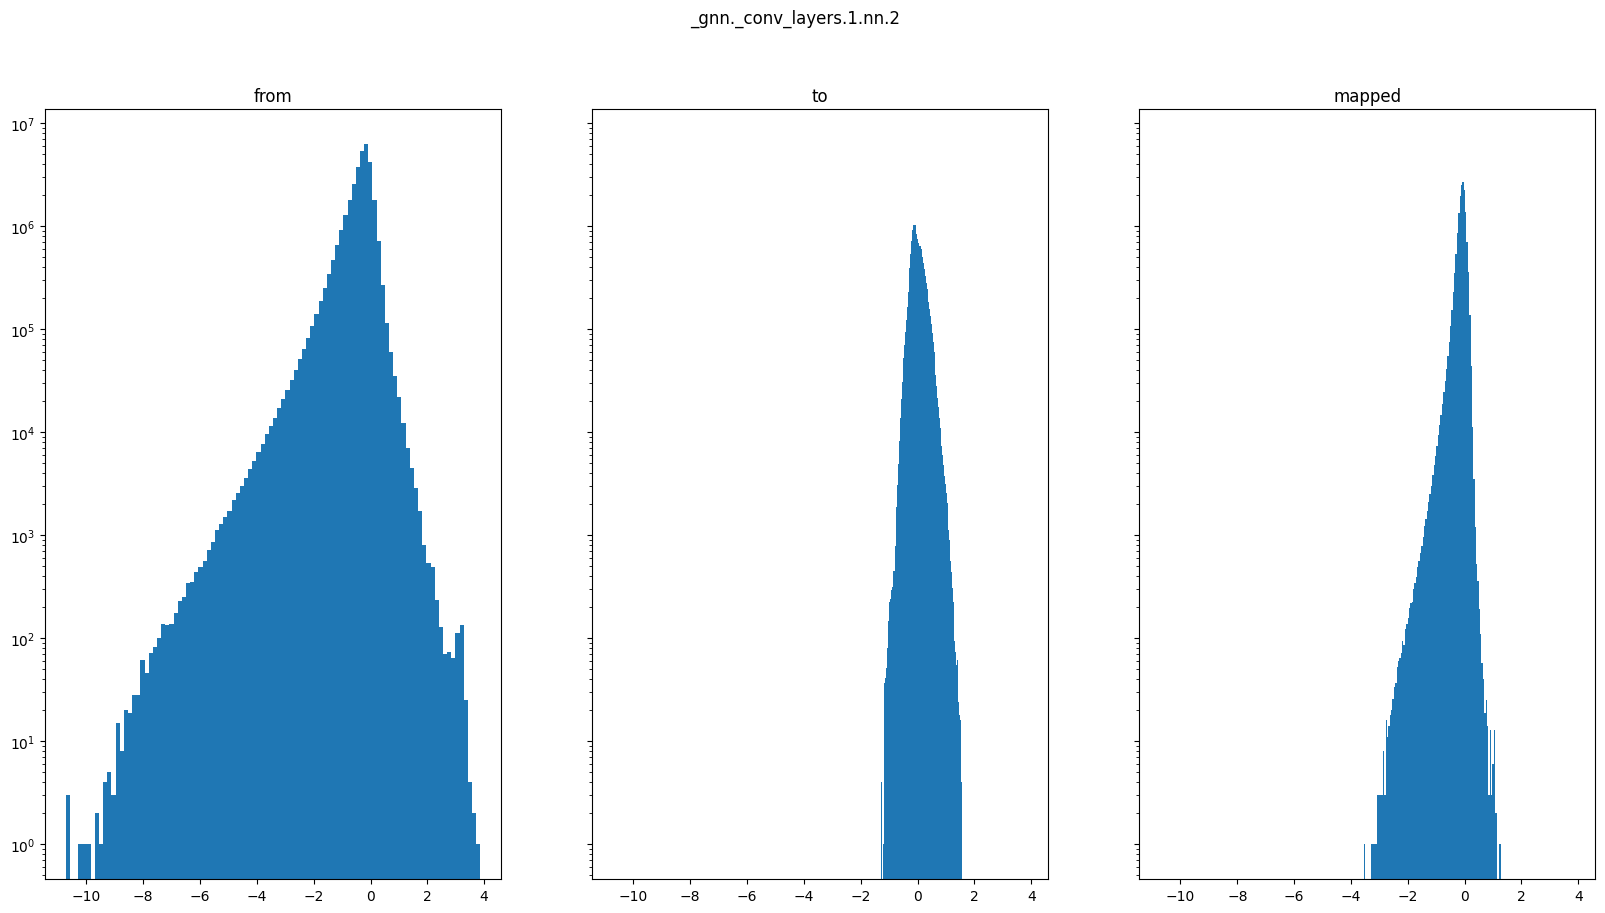

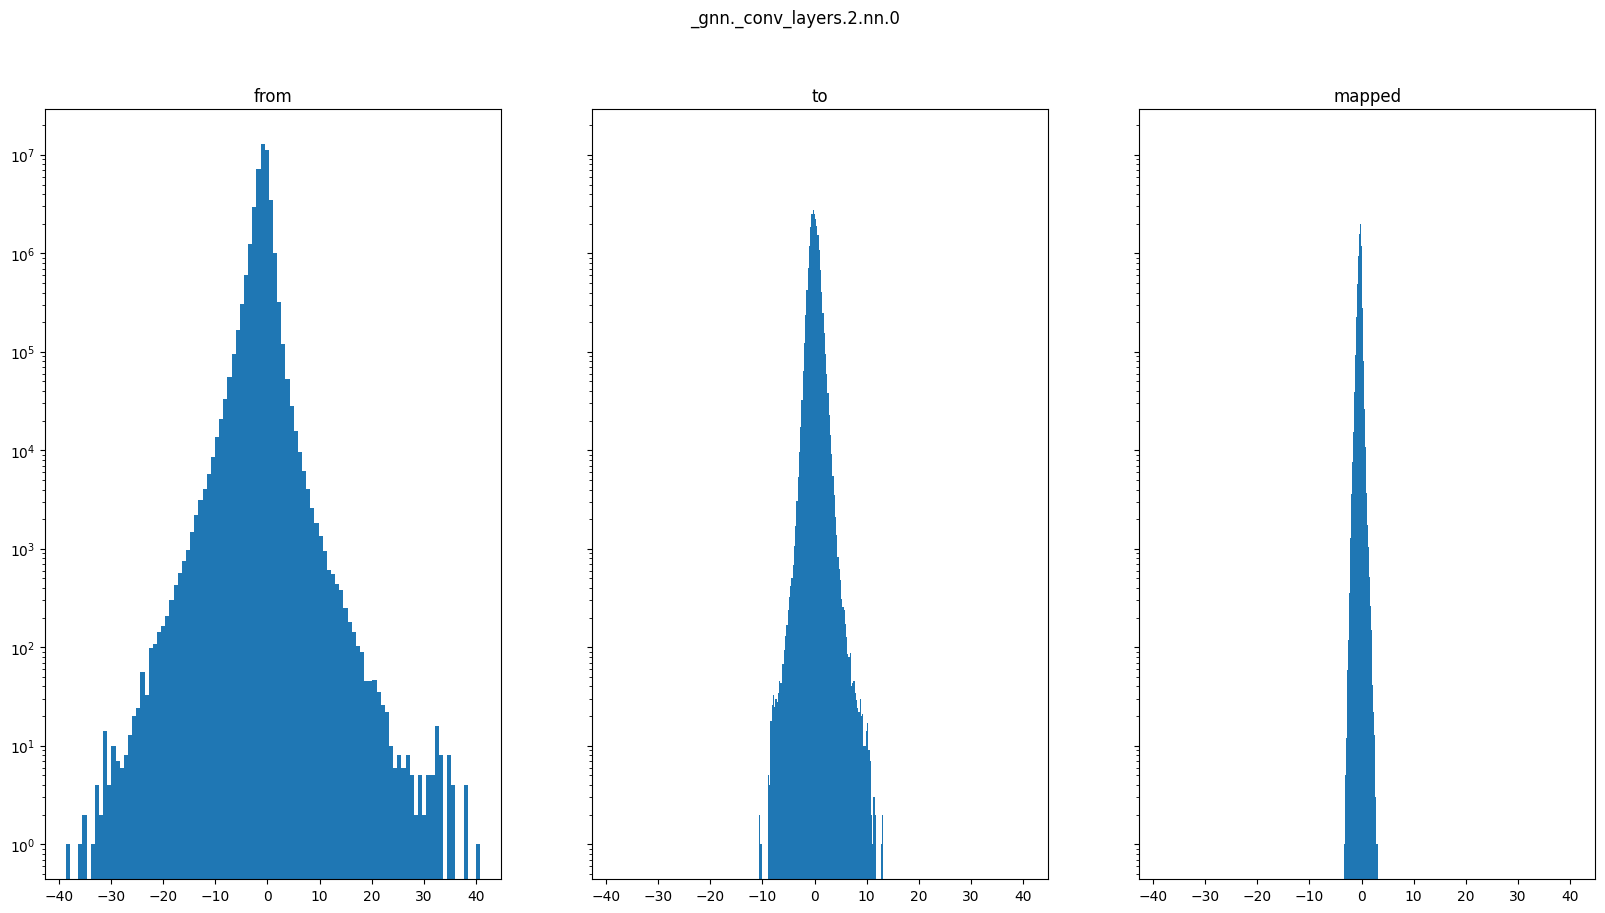

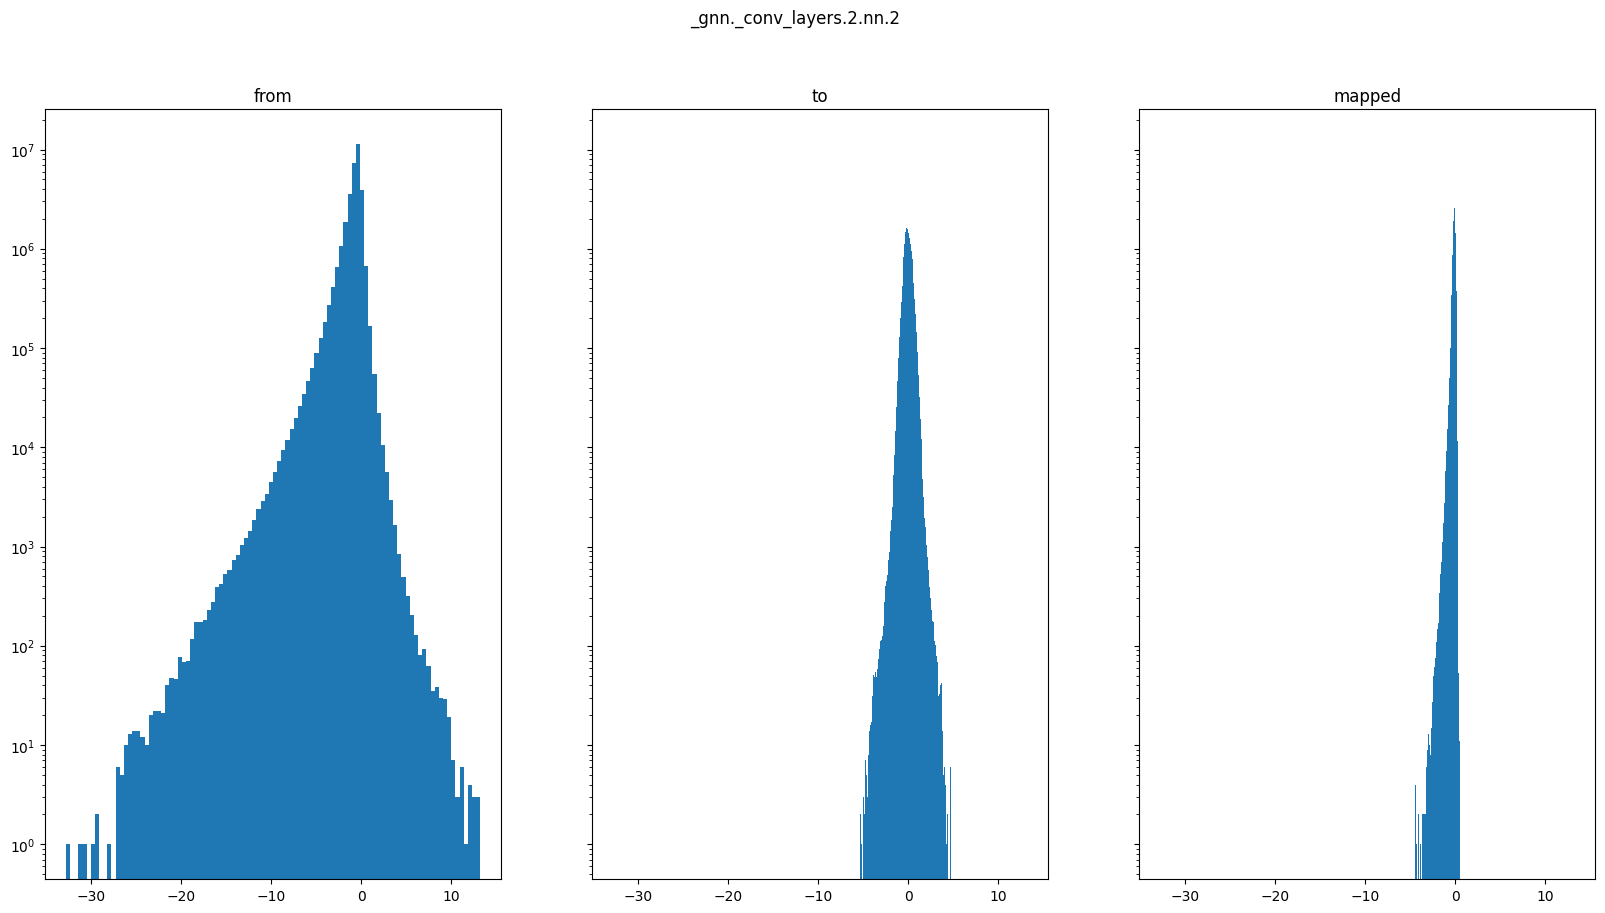

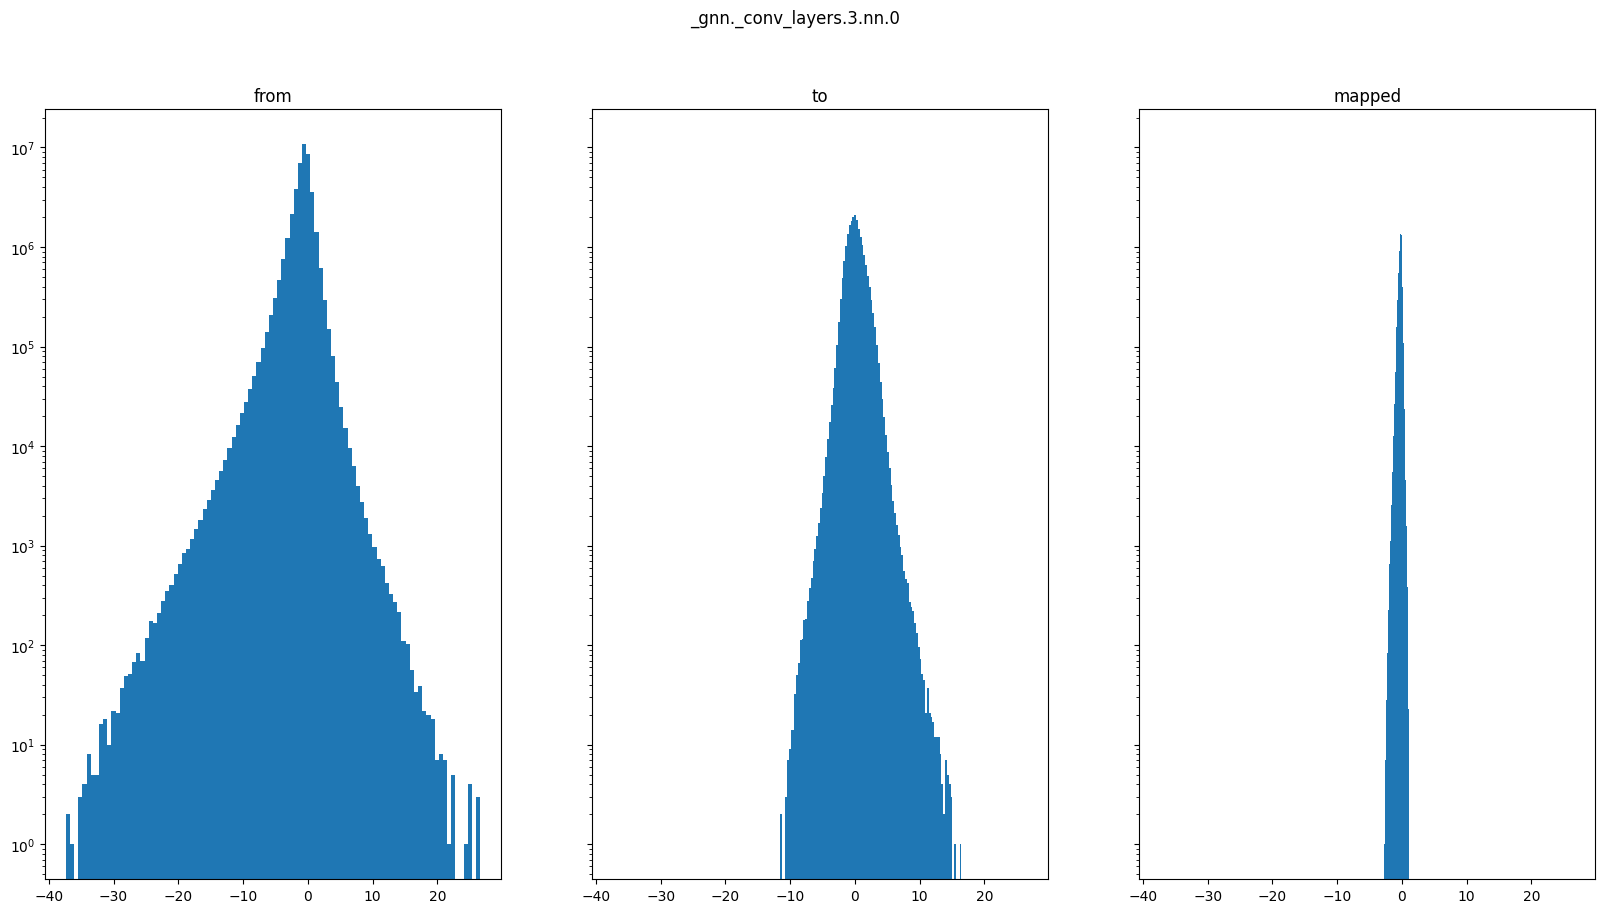

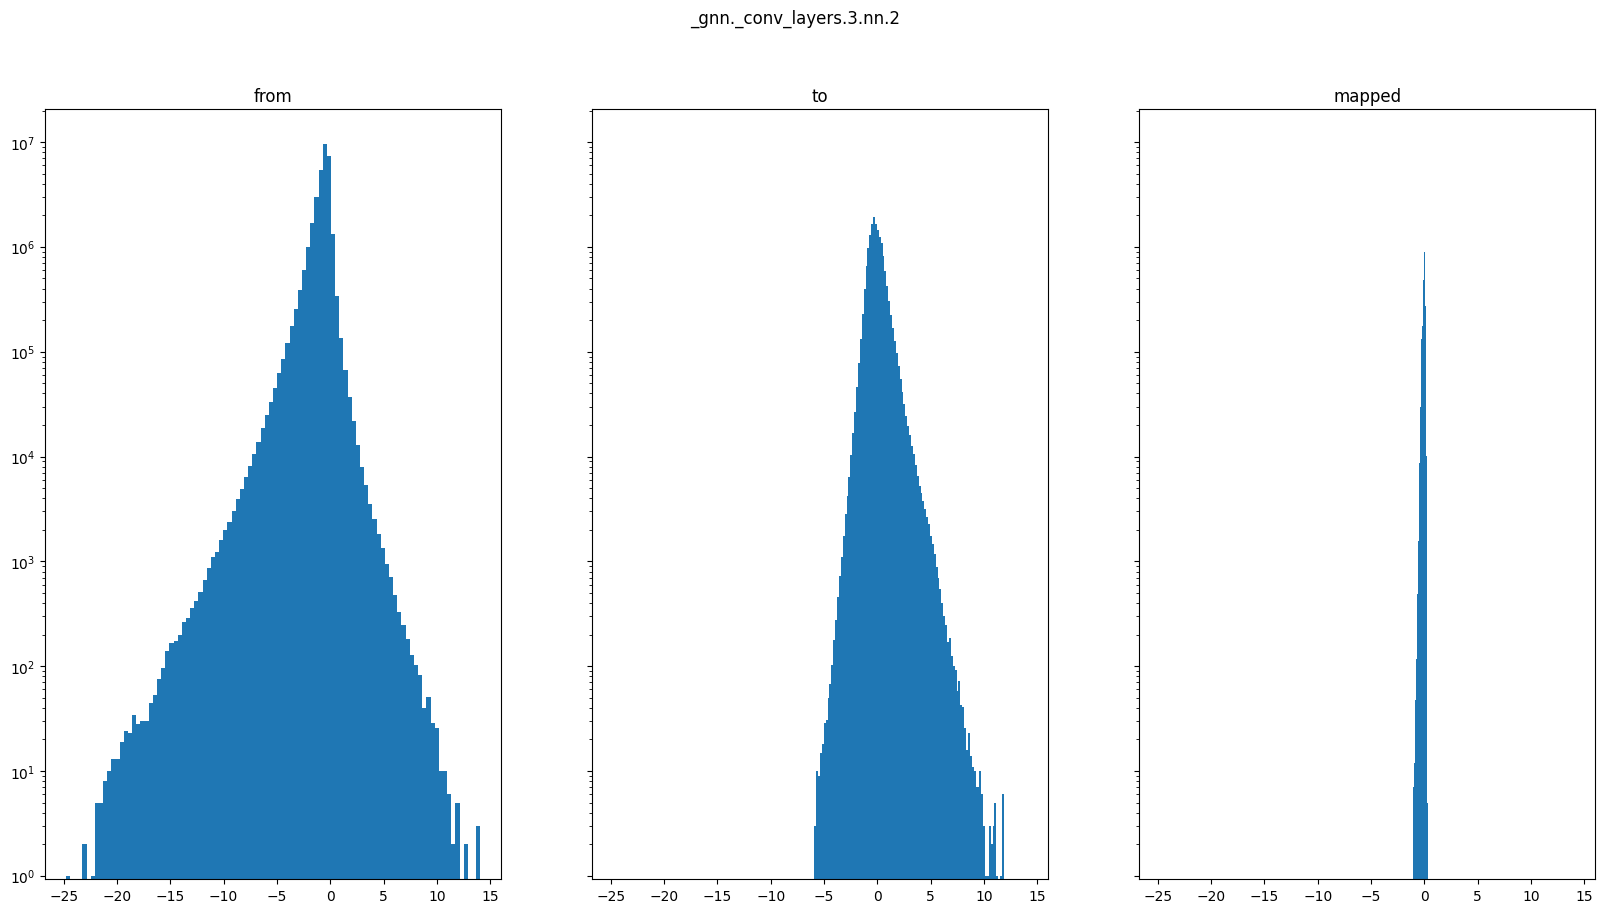

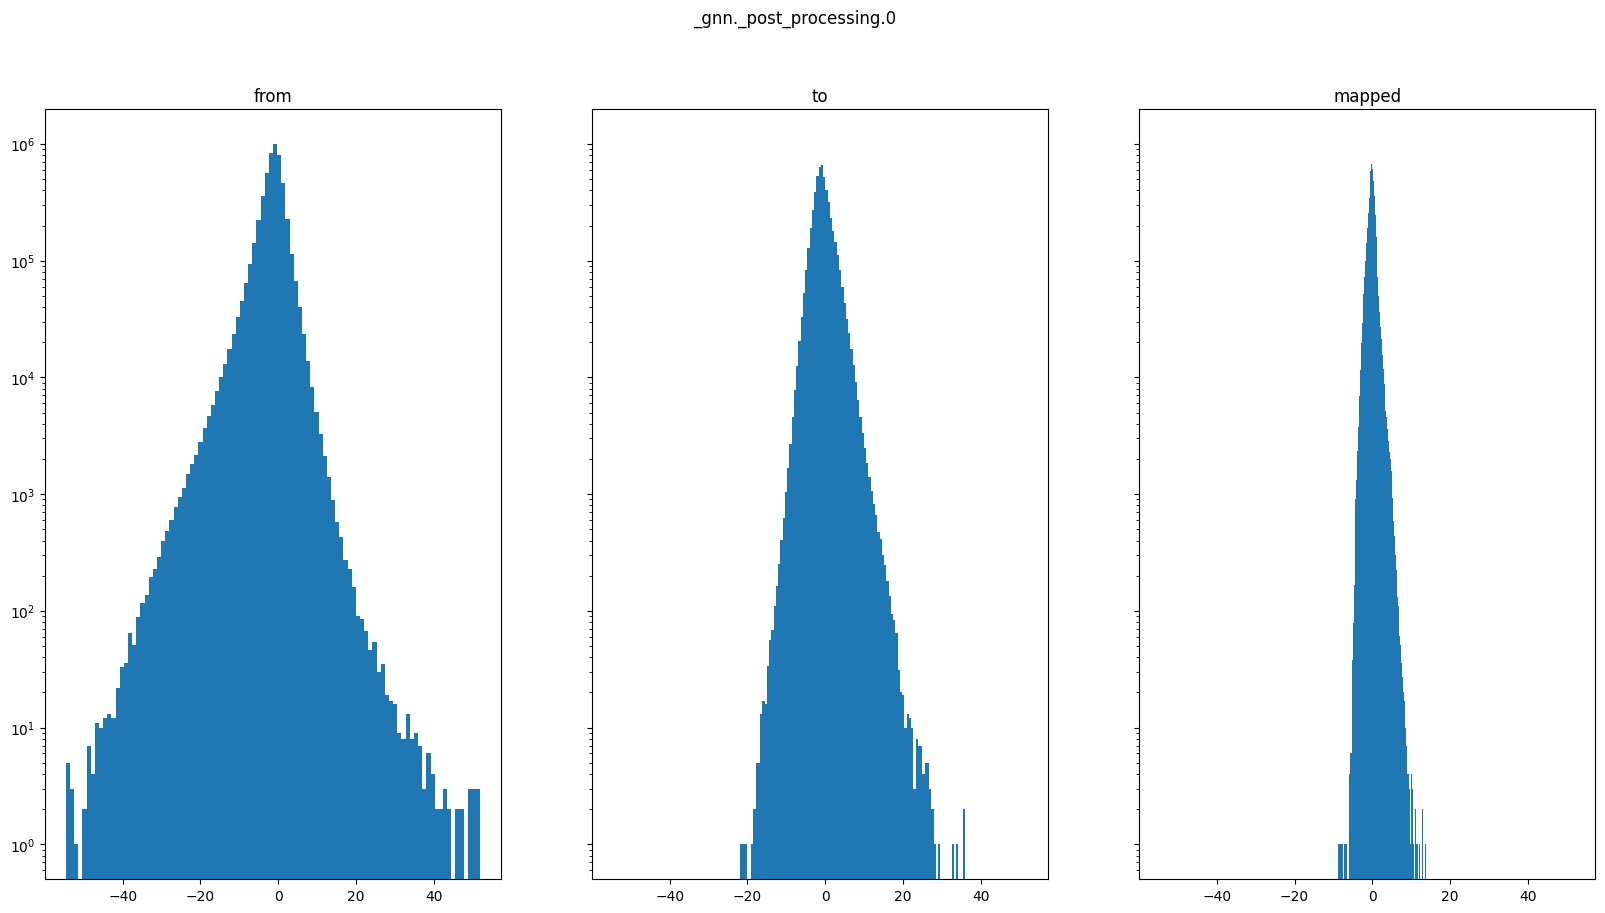

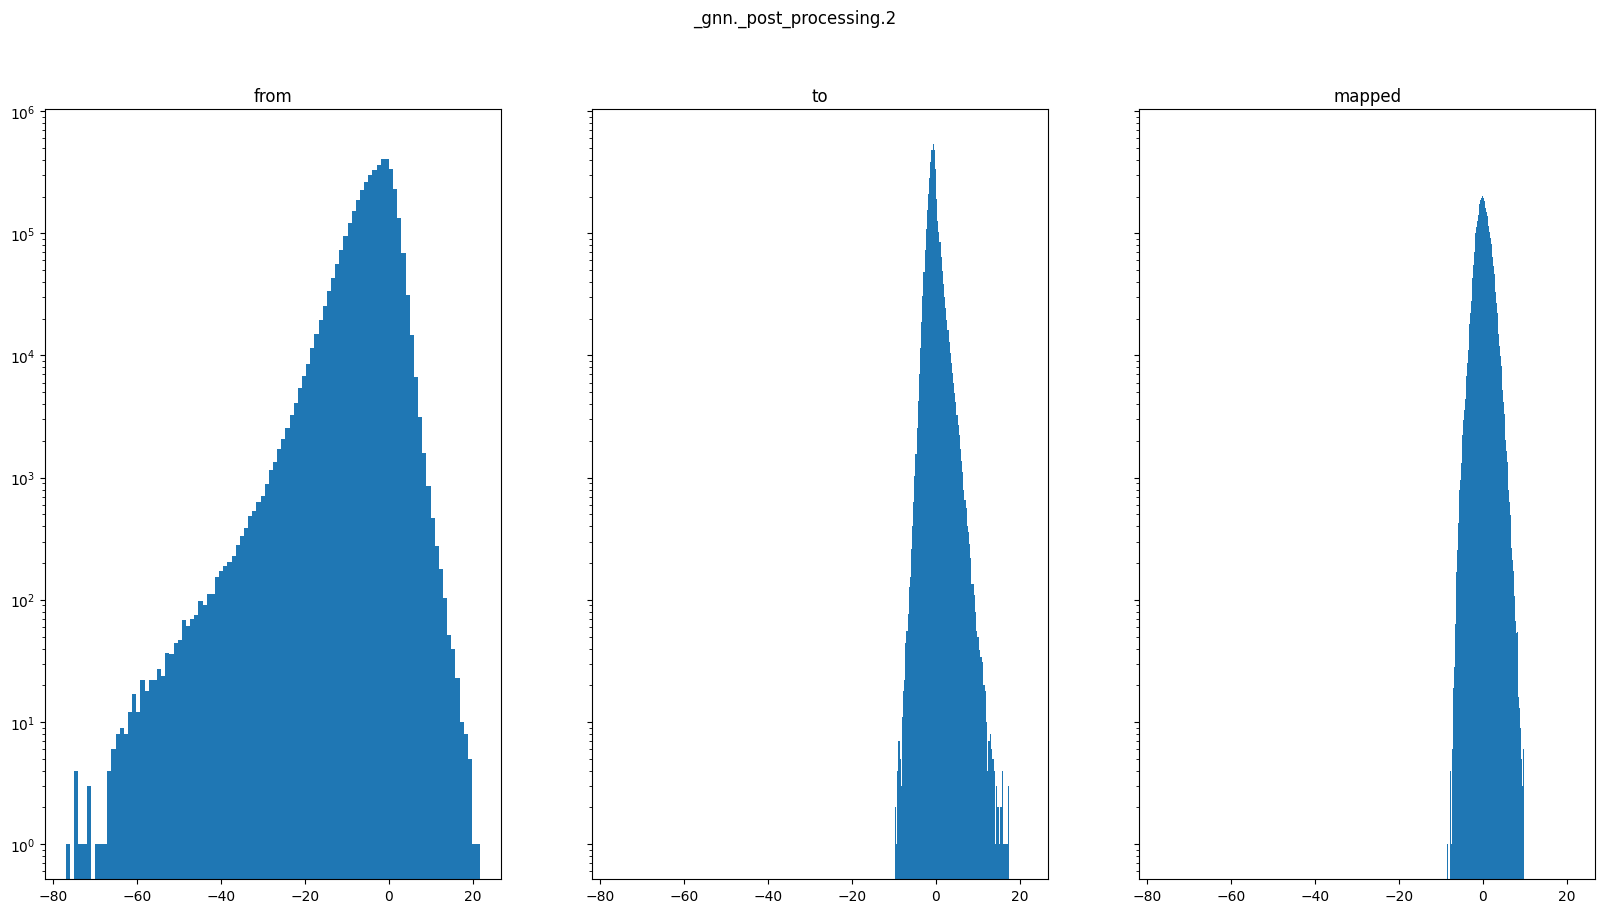

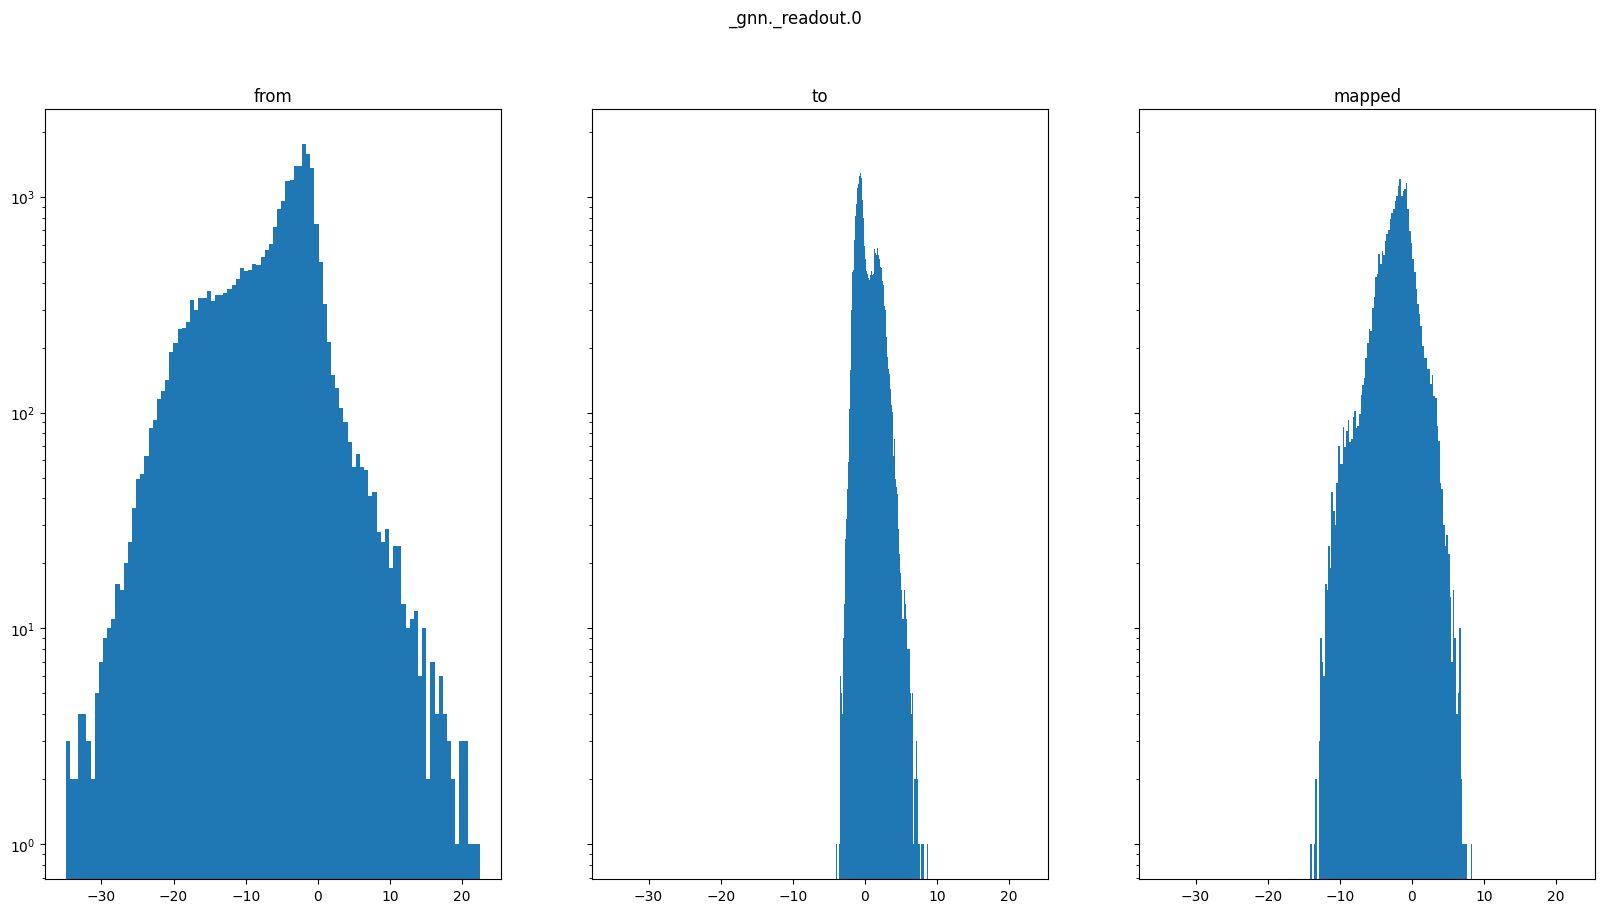

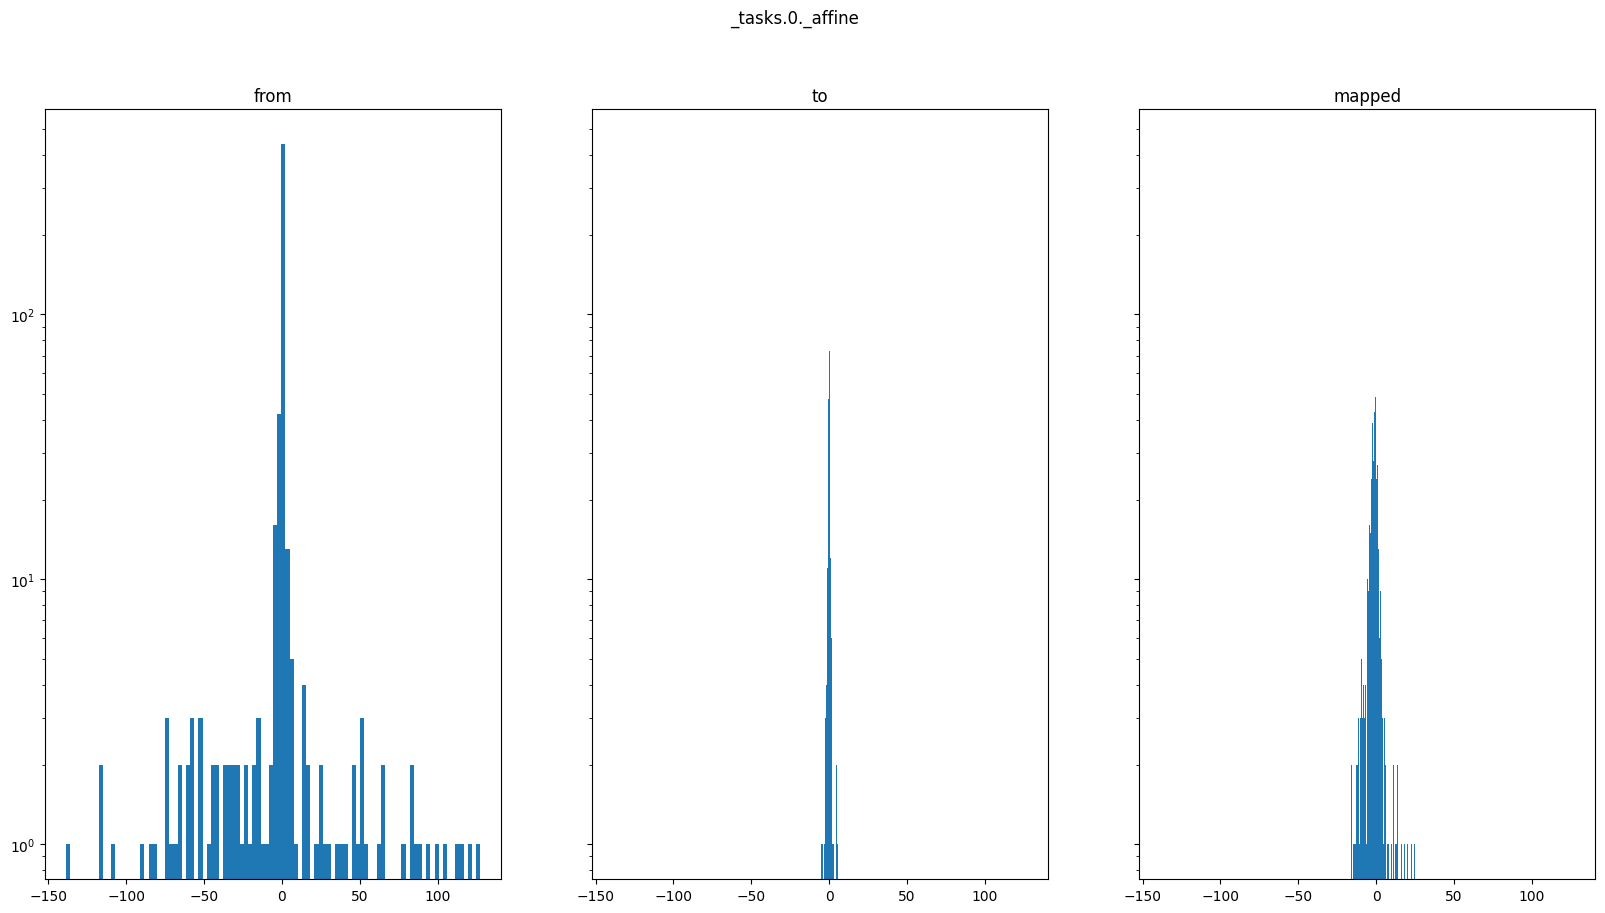

In [11]:
plt.close('all')
for ln, acts in zip(
    zip(*[activations[i].keys() for i in range(len(activations))]),
    zip(*[activations[i].values() for i in range(len(activations))])
):
    fig, axes = plt.subplots(1, len(acts), figsize=(20, 10), sharey=True, sharex=True)
    fig.suptitle(ln[0])
    print(ln[0], [a.shape for a in acts])
    print(ln[0], [a.min().item() for a in acts])
    print(ln[0], [a.max().item() for a in acts])
    a_std_rel = []
    for i, (model_name, a) in enumerate(zip(models_names, acts)):
        a_flattened = a.flatten().cpu().numpy()
        # if model_name == 'mapped' and ln[0] != '_gnn._conv_layers.0.nn.0':
        #     a_flattened = a_flattened / 0.7
        if i == 0:
            a_std_rel.append(1)
        else:
            a_std_rel.append(a_flattened.std() / a_std_rel[0])
        axes[i].hist(a_flattened, bins=100)
        axes[i].set_yscale('log')
        axes[i].set_title(model_name)
    print(ln[0], a_std_rel)
    print()

In [13]:
for idx, (
    (layer0_name, fc_layer0_weight), 
    (layer1_name, fc_layer1_weight),
    (layer2_name, fc_layer2_weight),
) in enumerate(zip(
    models['from'].named_parameters(), 
    models['to'].named_parameters(),
    models['mapped'].named_parameters(),
)):
    with torch.no_grad():
        s1 = (((fc_layer0_weight.abs() ** 2).sum() ** 0.5) / ((fc_layer1_weight.abs() ** 2).sum() ** 0.5)).cpu().numpy()
        s2 = (((fc_layer0_weight.abs() ** 2).sum() ** 0.5) / ((fc_layer2_weight.abs() ** 2).sum() ** 0.5)).cpu().numpy()
        print(layer0_name, s1, s2)

_gnn._conv_layers.0.nn.0.weight 2.2713735 1.8385075
_gnn._conv_layers.0.nn.0.bias 0.9212984 1.8216871
_gnn._conv_layers.0.nn.2.weight 2.6129503 1.1324315
_gnn._conv_layers.0.nn.2.bias 1.3338947 1.8151666
_gnn._conv_layers.1.nn.0.weight 3.165033 1.7882333
_gnn._conv_layers.1.nn.0.bias 2.9694026 1.6795707
_gnn._conv_layers.1.nn.2.weight 3.1180804 1.7496188
_gnn._conv_layers.1.nn.2.bias 2.5728428 1.8727916
_gnn._conv_layers.2.nn.0.weight 2.739153 1.8516842
_gnn._conv_layers.2.nn.0.bias 3.375706 1.5683553
_gnn._conv_layers.2.nn.2.weight 2.3673923 1.6539748
_gnn._conv_layers.2.nn.2.bias 3.1932704 1.8278457
_gnn._conv_layers.3.nn.0.weight 2.2991085 1.7373873
_gnn._conv_layers.3.nn.0.bias 4.245076 1.5847596
_gnn._conv_layers.3.nn.2.weight 1.7975521 1.6879028
_gnn._conv_layers.3.nn.2.bias 2.9184854 1.7549227
_gnn._post_processing.0.weight 2.8182735 0.9389487
_gnn._post_processing.0.bias 2.7465086 1.0000336
_gnn._post_processing.2.weight 2.3928106 1.0000591
_gnn._post_processing.2.bias 2.320386

In [17]:
test_dataloader = make_dataloader(db = config_small['inference_database_path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = config_small['batch_size'],
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [18]:
# from torchviz import make_dot

# x = next(iter(test_dataloader)).cpu()
# y = model_small_seed_0.cpu()(x)

# make_dot(sum(y) / len(y), params=dict(list(model_small_seed_0.named_parameters()))).render("rnn_torchviz", format="png")

In [19]:
resilts = defaultdict(list)
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        for model_name, model in models.items():
            resilts[model_name].append(model(batch.cuda()))
    if i > 100:
        break
print(*[model_name for model_name in resilts.keys()])
for x in zip(*[resilts[model_name] for model_name in resilts.keys()]):
    print([(np.abs(y[0].cpu().numpy()) ** 2).sum() ** 0.5 for y in x])

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [45756], which does not match the required output shape [7626, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [66378], which does not match the required output shape [11063, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resiz

graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [47322], which does not match the required output shape [7887, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [54636], which does not match the required output shape [9106, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 19:00:02 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [62112], which does not match the required output shape [10352, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [90546], which does not match the required output shape [15091, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resi

small_seed_0_epochs_10 small_seed_1_epochs_10 large_seed_0_epochs_10 large_seed_0_epochs_1 small_seed_0_epochs_10_mapped large_seed_0_epochs_10_mapped large_seed_0_epochs_1_mapped
[415.1027545981838, 395.45197638272083, 415.8800157497352, 10.032850476513742, 287.5507835583134, 329.88003264444484, 363.46197789452475]
[356.06117802984363, 354.9598678900194, 366.1581796164057, 10.028302006096958, 401.5412883502766, 277.7065813273067, 335.49601804641435]
[261.62513437645856, 287.632510223549, 274.34256642016015, 10.030881120310653, 224.38001387155674, 153.05763824455153, 195.01765745375468]
[273.8791362079266, 269.79597326035093, 250.46252526575708, 10.034587554438664, 306.62516561348974, 163.18435821372404, 220.52115119643287]
[394.53734772515514, 382.578545856926, 396.29067220286674, 10.032472910270553, 291.25710828235594, 219.4414340291049, 327.1673644711526]
[290.25453538661543, 285.9921873932923, 311.57389021306005, 10.025941388838351, 221.29220995665437, 188.90016791284225, 198.64345

In [21]:
vs = []
for a, b, c in zip(resilts['small_seed_0_epochs_10'], resilts['small_seed_1_epochs_10'], resilts['small_seed_0_epochs_10_mapped']):
    print(
        v := ((np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5) / ((
            ((np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5) +
            ((np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5)
        ) / 2)
    )
    vs.append(v)

0.7095160204921132
1.1294779265803423
0.8170300989982932
1.1279720563752635
0.7495847419612518
0.7680467452868273
1.051109980405257
0.6142273133354276
0.6901533824580012
0.7931526377978917
0.6918536419928245
0.7539773026888663
0.891725404556925
0.7814086076058229
0.8163305895207107
0.4932066422722332
0.7906840447751871
1.0245448490296825
0.6544301945659287
0.9033840846268731
0.5773952889194729
0.49570851081282497
0.7542822174246592
0.7127953389443905
0.7460334991942145
0.7143116447828062
1.0720579004316062
1.1110481261092013
0.7843812261504416
0.8110464308053563
0.7830590646118877
0.8037563319732945
0.879610775616401
0.5668422568278308
0.757190692861585
0.923452991859339
0.9206133953779343
0.9521968985886552
0.6286880781381674
0.7777520669814951
0.8898266055588712
0.7964135117980126
0.694772186067916
0.8934746070196051
0.6485835271926881
0.5325718708332022
0.7390420355835885
0.7383249940651126
0.9222885447666348
1.0009808735045442
0.6375048177324766
0.9284486061801048
0.847816100267788

In [22]:
sum(vs) / len(vs)

0.7726574967815749

In [23]:
vs = []
for a, b, c in zip(resilts['small_seed_0_epochs_10'], resilts['small_seed_1_epochs_10'], resilts['large_seed_0_epochs_10_mapped']):
    print(
        v := ((np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5) / ((
            ((np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5) +
            ((np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5)
        ) / 2)
    )
    vs.append(v)

0.81396115533182
0.7811486957268102
0.5573254728425838
0.6003010083478746
0.5647585793609223
0.6556225326594733
0.5658098245456549
0.6371791929181386
0.5762342649065892
0.6856116726632424
0.5730182340108112
0.5243230120309993
0.6810715534093259
0.5601319243792774
0.6364419732447478
0.6467295183048599
0.7712999027813472
0.6372911619504624
0.7427104834019236
0.5359980136978637
0.588832709673983
0.5806186383737194
0.6152183540069633
0.6551121383390787
0.561381820310565
0.7638183372864097
0.6244175327709078
0.9306753032572472
0.7468965195554566
0.5739465958004973
0.6101235907302256
0.8387605663314748
0.910773652374007
0.6190182798478975
0.6229535004087301
0.5866140566361698
0.6052440747571366
0.5518280216470524
0.6073178711346118
0.773803818945839
0.692418482503534
0.6045844517215857
0.8281842519078492
0.6317106026801643
0.6518758496814187
0.5302855096704906
0.6337385976393616
0.6416659945722241
0.6056188367177983
0.4887553137295378
0.6690685070815672
0.8799475092729682
0.6663473324720259


In [24]:
sum(vs) / len(vs)

0.6577436508022738

## Inference & Evaluation

With a trained model loaded into memory, we can now apply the model to batch_51. The following cells will start inference (or load in a csv with predictions, if you're in a hurry) and plot the results. 

In [25]:
def convert_to_3d(df: pd.DataFrame) -> pd.DataFrame:
    """Converts zenith and azimuth to 3D direction vectors"""
    df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
    df['true_y'] = np.sin(df['azimuth']) * np.sin(df['zenith'])
    df['true_z'] = np.cos(df['zenith'])
    return df

def calculate_angular_error(df : pd.DataFrame) -> pd.DataFrame:
    """Calcualtes the opening angle (angular error) between true and reconstructed direction vectors"""
    df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
    return df

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_small_seed_0, config_small))) 
# df.to_hdf('results/small_0.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:14<00:00, 14.82it/s]
graphnet: INFO     2023-03-04 16:59:43 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [26]:
torch.cuda.empty_cache()

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_small_seed_1, config_small))) 
# df.to_hdf('results/small_1.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:14<00:00, 14.82it/s]
graphnet: INFO     2023-03-04 17:02:31 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large, config_large)))
# df.to_hdf('results/large.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]
graphnet: INFO     2023-03-04 18:18:56 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_random, config_large_random)))
# df.to_hdf('results/large_random.h5', key='df', mode='w')

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_mapped, config_large)))
# df.to_hdf('results/large_mapped.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s]
graphnet: INFO     2023-03-04 18:23:27 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_small_mapped, config_small)))
# df.to_hdf('results/small_mapped.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:15<00:00, 14.79it/s]
graphnet: INFO     2023-03-04 17:05:19 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [27]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(models['large_seed_0_epochs_1'], config_large)))
df.to_hdf('results/large_seed_0_epochs_1.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [03:45<00:00,  8.86it/s]
graphnet: INFO     2023-03-04 19:06:46 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [28]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(models['large_seed_0_epochs_1_mapped'], config_large)))
df.to_hdf('results/large_seed_0_epochs_1_mapped.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [03:47<00:00,  8.81it/s]
graphnet: INFO     2023-03-04 19:11:08 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [29]:
results = {
    'small_seed_0_epochs_10': pd.read_hdf('results/small_0.h5', key='df'),
    'small_seed_1_epochs_10': pd.read_hdf('results/small_1.h5', key='df'),
    'large_seed_0_epochs_10': pd.read_hdf('results/large.h5', key='df'),
    'large_seed_0_epochs_1': pd.read_hdf('results/large_seed_0_epochs_1.h5', key='df'),
    'small_seed_0_epochs_10_mapped': pd.read_hdf('results/small_mapped.h5', key='df'),
    'large_seed_0_epochs_10_mapped': pd.read_hdf('results/large_mapped.h5', key='df'),
    'large_seed_0_epochs_1_mapped': pd.read_hdf('results/large_seed_0_epochs_1_mapped.h5', key='df'),
}

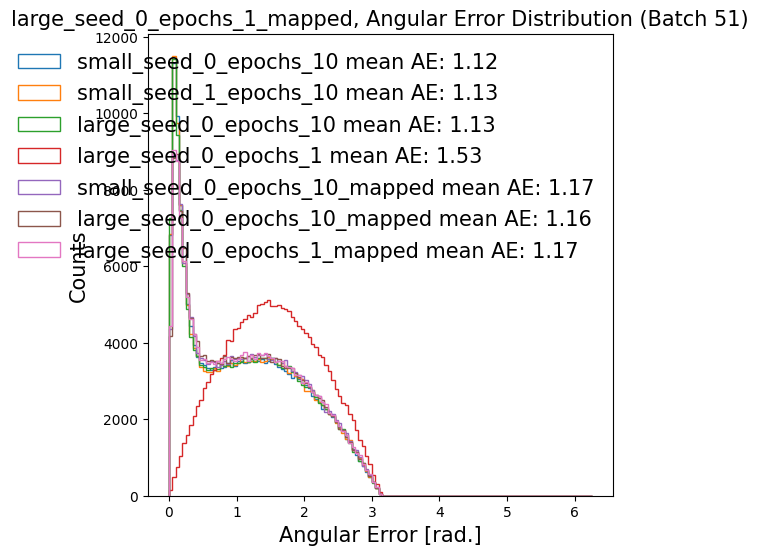

In [30]:
fig = plt.figure(figsize = (6,6))
for name, result in results.items():
    plt.hist(result['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'{name} mean AE: {np.round(result["angular_error"].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon = False, fontsize = 15)

So the pre-trained dynedge seems to perform quite well. Another interesting feature of the reconstruction is that dynedge (when coupled with the[ DirectionReconstructionWithKappa](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/models/task/reconstruction.py#L45) is that dynedge estimated *kappa* the concentration parameter from the vonMisesFisher distribution. Kappa is analogus to sigma via sigma = 1/sqrt(kappa), and the quality of the direction estimate should be highly correlated with this parameter. 

In [ ]:
cut_threshold = 0.5
for name, result in results.items():
    fig = plt.figure(figsize = (6,6))
    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) <= cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma <= {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) <= cut_threshold].mean(),2)}')

    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) > cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma > {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) > cut_threshold].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
    plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
    plt.legend(frameon = False, fontsize = 15)

As you can see, the variable can be used to distinguish "good" and "bad" reconstructions with some confidence. 

## A few hints for your neutrino data science journey!

* The configuration of dynedge shown in this notebook is the so-called "baseline". It's not optimized for high energy neutrinos, so you might be able to squeeze out a bit more performance by tuning hyperparameters or making larger modifications; such as switching out the learning rate scheduler or choosing a different loss function, etc.

* You can use the kappa variable to group events into different categories. Perhaps training a seperate reconstruction method for each performs better?

* You may want to adjust the [ParquetDataset](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/data/parquet/parquet_dataset.py#L11) such that it works with the competition data. This would allow you to train / infer directly on the competition files (No conversion to sqlite needed). Feel free to contribute this to the repository!


Good luck!